In [1]:
cd ../utilities/

/home/gustav/Documents/DD142X/code/utilities


In [2]:
import numpy as np
from spectogram_script import load_all, epochs_as_rows
from plotting import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
freqs, dataDict = load_all()
epoch_idxs = (freqs > 5) & (freqs < 50)
freqs = freqs[epoch_idxs]
epochs = epochs_as_rows(dataDict)[
     : ,
    epoch_idxs
]

epoch_size = 2 ** 11
Fs = 16000.

print(epochs.shape)
print(freqs.shape)
print(freqs)

(367629, 46)
(46,)
[ 5.859375   6.8359375  7.8125     8.7890625  9.765625  10.7421875
 11.71875   12.6953125 13.671875  14.6484375 15.625     16.6015625
 17.578125  18.5546875 19.53125   20.5078125 21.484375  22.4609375
 23.4375    24.4140625 25.390625  26.3671875 27.34375   28.3203125
 29.296875  30.2734375 31.25      32.2265625 33.203125  34.1796875
 35.15625   36.1328125 37.109375  38.0859375 39.0625    40.0390625
 41.015625  41.9921875 42.96875   43.9453125 44.921875  45.8984375
 46.875     47.8515625 48.828125  49.8046875]


In [4]:
n_components = 12
n_features = epochs.shape[1]
pca_model = PCA(n_components = n_components).fit(epochs.copy())

In [5]:
for i in range(0, n_components):
    print(f"Component {i} explains\t{round(100 * pca_model.explained_variance_ratio_[i], 2)}%\tvariance.\
        \tSum = {pca_model.explained_variance_ratio_[ : i + 1].sum()}")

Component 0 explains	52.04%	variance.        	Sum = 0.520411614512838
Component 1 explains	12.75%	variance.        	Sum = 0.6478677778723478
Component 2 explains	8.15%	variance.        	Sum = 0.7294162404228514
Component 3 explains	6.92%	variance.        	Sum = 0.7985843698650472
Component 4 explains	4.62%	variance.        	Sum = 0.8447866239212437
Component 5 explains	3.63%	variance.        	Sum = 0.8810499699163835
Component 6 explains	3.03%	variance.        	Sum = 0.9113658415657195
Component 7 explains	2.29%	variance.        	Sum = 0.9342689084047304
Component 8 explains	1.81%	variance.        	Sum = 0.9523453027045985
Component 9 explains	1.45%	variance.        	Sum = 0.966806549774291
Component 10 explains	1.12%	variance.        	Sum = 0.9780187980830002
Component 11 explains	0.9%	variance.        	Sum = 0.9869997522488672


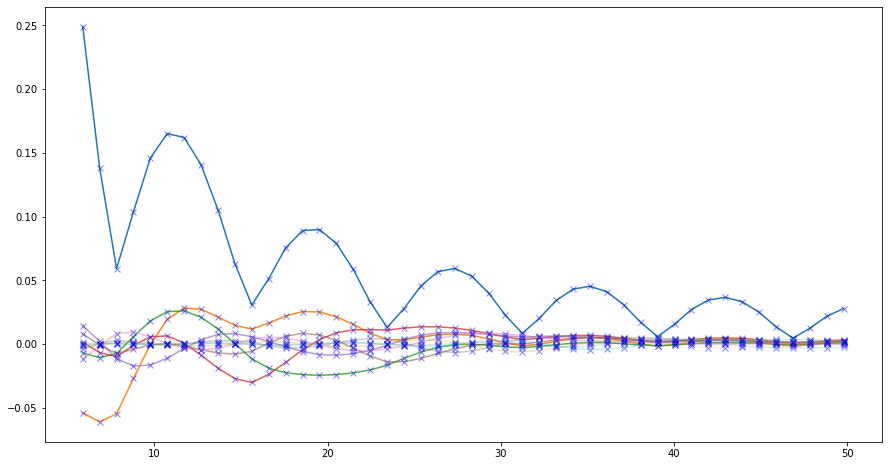

In [9]:
plt.figure(figsize = (15, 8))
for idx, comp in enumerate(pca_model.components_):
    plt.plot(freqs, comp * pca_model.explained_variance_ratio_[idx], alpha = 1 - idx/12)
    plt.plot(freqs, comp * pca_model.explained_variance_ratio_[idx], 'bx', alpha = 0.5)
plt.show()

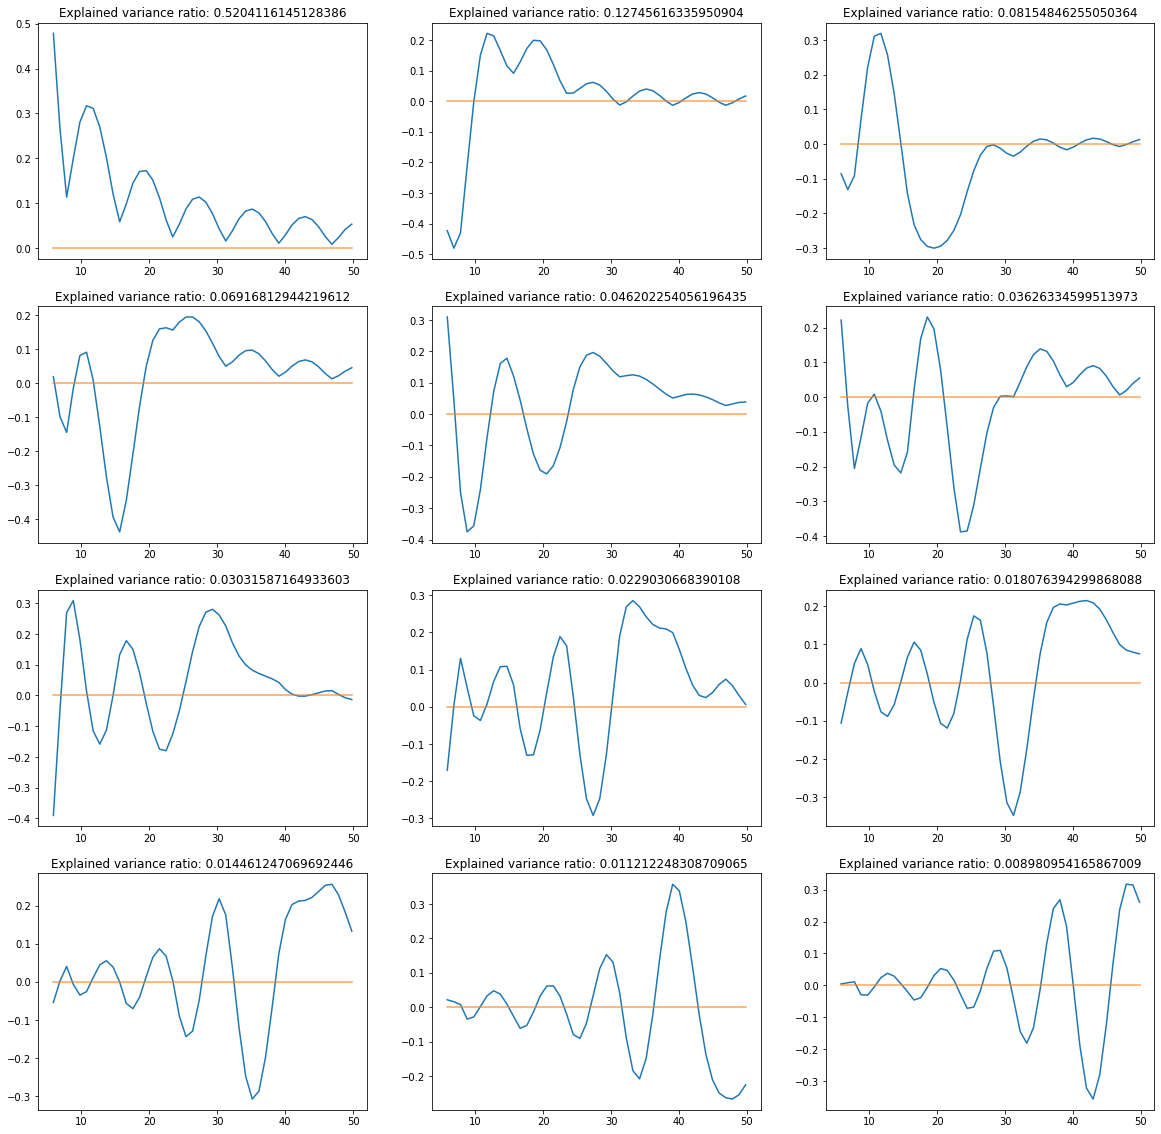

In [10]:
plt.close()
plt.figure(figsize = (20, 20))
for idx, comp in enumerate(pca_model.components_):
    plt.subplot(4, 3, idx + 1)
    plt.title(f"Explained variance ratio: {pca_model.explained_variance_ratio_[idx]}")
    plt.plot(freqs, comp)
    plt.plot([np.min(freqs), np.max(freqs)], [0, 0], alpha = 0.7)
plt.show()

In [133]:
n_animals = len(dataDict.keys())
fig_n = 0
plt.figure(figsize = (9 * n_animals, 10 * n_animals))
for animal1, channels1 in dataDict.items():
    for animal2, channels2 in dataDict.items():
        
        ep1, ep2 = [
            pca_model.transform(
                np.concatenate([
                    v for _, v in channels.items()
                ], axis = 0)[ : , epoch_idxs].copy()
            )[ : , 0 : 2]
            for channels in (channels1, channels2)
        ]
        
        # Fake bounds for simultaneous scaled rastering
        maxx1 = np.max((
            np.max(ep1[:, 0]),
            np.max(ep2[:, 0])
        ))
        minx1 = np.max((
            np.min(ep1[:, 0]),
            np.min(ep2[:, 0])
        ))
        maxx2 = np.max((
            np.max(ep1[:, 1]),
            np.max(ep2[:, 1])
        ))
        minx2 = np.max((
            np.min(ep1[:, 1]),
            np.min(ep2[:, 1])
        ))
        
        p1 = np.array((maxx1, maxx2))
        p2 = np.array((maxx1, minx2))
        p3 = np.array((minx1, maxx2))
        p4 = np.array((minx1, minx2))
        pts = np.array((p1, p2, p3, p4))
        ep1 = np.concatenate((ep1, pts), axis = 0)
        ep2 = np.concatenate((ep2, pts), axis = 0)
        
        side = 60
        red = rasterize(ep1, side)
        blu = rasterize(ep2, side)
        red /= np.max(red)
        blu /= np.max(blu)
        raster = np.zeros((side, side, 3))
        raster[ : , : , 0] = red
        raster[ : , : , 2] = blu
        
        fig_n += 1
        plt.subplot(n_animals, n_animals, fig_n)
        for i in range(0, side):
            for j in range(0, side):
                if np.linalg.norm(raster[i, j]) < 0.03:
                    raster[i, j] = 1
        plt.imshow(raster)
        plt.xlabel(f"Explained variance ratio {round(pca_model.explained_variance_ratio_[1], 2)}\
        \nBounds {round(minx2, 2)} - {round(maxx2, 2)}")
        plt.ylabel(f"Explained variance ratio {round(pca_model.explained_variance_ratio_[0], 2)}\
        \nBounds {round(maxx1, 2)} - {round(minx1, 2)}")
        plt.title(f"{animal1} in red - {animal2} in blue\
        \n{round(pca_model.explained_variance_ratio_[0:2].sum(), 2)} explained variance ratio\
        \n{animal1} n: {ep1.shape[0] - 4} - {animal2} n: {ep2.shape[0] - 4}")
        
plt.savefig("../_data/PCA/xref_n_strict.png")
plt.close()

In [134]:
n_animals = len(dataDict.keys())
fig_n = 0
plt.figure(figsize = (9 * n_animals, 10 * n_animals))
for animal1, channels1 in dataDict.items():
    for animal2, channels2 in dataDict.items():
        
        ep1, ep2 = [
            pca_model.transform(
                np.concatenate([
                    v for _, v in channels.items()
                ], axis = 0)[ : , epoch_idxs].copy()
            )[ : , 0 : 2]
            for channels in (channels1, channels2)
        ]
        
        # Fake bounds for simultaneous scaled rastering
        maxx1 = np.max((
            np.max(ep1[:, 0]),
            np.max(ep2[:, 0])
        ))
        minx1 = np.max((
            np.min(ep1[:, 0]),
            np.min(ep2[:, 0])
        ))
        maxx2 = np.max((
            np.max(ep1[:, 1]),
            np.max(ep2[:, 1])
        ))
        minx2 = np.max((
            np.min(ep1[:, 1]),
            np.min(ep2[:, 1])
        ))
        
        p1 = np.array((maxx1, maxx2))
        p2 = np.array((maxx1, minx2))
        p3 = np.array((minx1, maxx2))
        p4 = np.array((minx1, minx2))
        pts = np.array((p1, p2, p3, p4))
        ep1 = np.concatenate((ep1, pts), axis = 0)
        ep2 = np.concatenate((ep2, pts), axis = 0)
        
        side = 60
        red = np.log2(rasterize(ep1, side) + 1)
        blu = np.log2(rasterize(ep2, side) + 1)
        red /= np.max(red)
        blu /= np.max(blu)
        raster = np.zeros((side, side, 3))
        raster[ : , : , 0] = red
        raster[ : , : , 2] = blu
        
        fig_n += 1
        plt.subplot(n_animals, n_animals, fig_n)
        for i in range(0, side):
            for j in range(0, side):
                if np.linalg.norm(raster[i, j]) < 0.03:
                    raster[i, j] = 1
        plt.imshow(raster)
        plt.xlabel(f"Explained variance ratio {round(pca_model.explained_variance_ratio_[1], 2)}\
        \nBounds {round(minx2, 2)} - {round(maxx2, 2)}")
        plt.ylabel(f"Explained variance ratio {round(pca_model.explained_variance_ratio_[0], 2)}\
        \nBounds {round(maxx1, 2)} - {round(minx1, 2)}")
        plt.title(f"log2 {animal1} in red - log2 {animal2} in blue\
        \n{round(pca_model.explained_variance_ratio_[0:2].sum(), 2)} explained variance ratio\
        \n{animal1} n: {ep1.shape[0] - 4} - {animal2} n: {ep2.shape[0] - 4}")
        
plt.savefig("../_data/PCA/xreflog2_n_strict.png")
plt.close()

In [6]:
all_pcs = pca_model.transform(
    np.concatenate([
        np.concatenate([
            vals for channel, vals in dataDict[session].items()
        ], axis = 0)
        for session in dataDict.keys()
    ], axis = 0)[ : , epoch_idxs].copy()
)
print(all_pcs.shape)

(367629, 12)


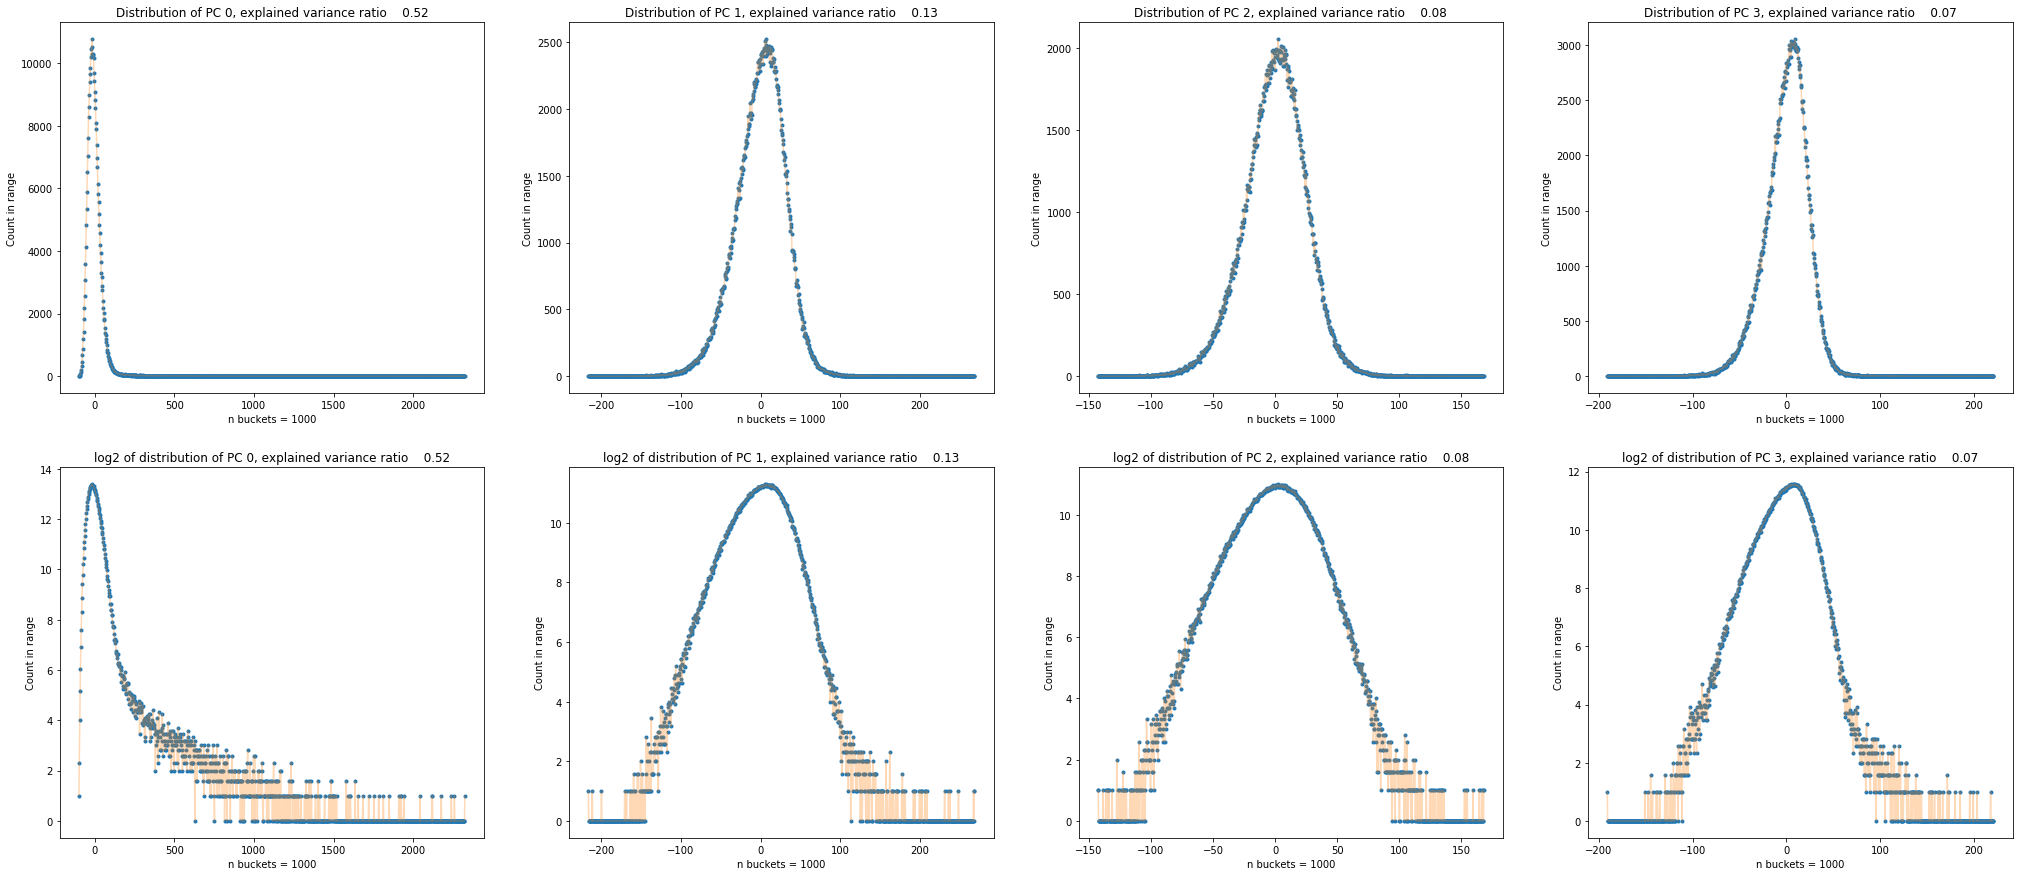

In [11]:
def toBoxes(data, n_boxes = 1000):
    lo = np.min(data)
    hi = np.max(data)
    incr = (hi - lo) / n_boxes
    ys = np.array([
        ((data >= lo + idx * incr) & (data <= lo + (idx + 1) * incr)).sum()
        for idx in np.arange(0, n_boxes)
    ])
    xs = np.array([
        lo + idx * incr for idx in np.arange(0, n_boxes)
    ])
    return xs, ys

n_buckets = 1000
plt.figure(figsize = (35, 15))
# Focus on 4 most important components
for i in range(0, 4):
    
    xs, ys = toBoxes(all_pcs[ : , i], n_buckets)
    
    plt.subplot(2, 4, i+1)
    plt.title(f"Distribution of PC {i}, explained variance ratio\
    {round(pca_model.explained_variance_ratio_[i], 2)}")
    plt.plot(xs, ys, '.')
    plt.plot(xs, ys, alpha = 0.3)
    plt.xlabel(f"n buckets = {n_buckets}")
    plt.ylabel("Count in range")
    
    plt.subplot(2, 4, i+5)
    plt.title(f"log2 of distribution of PC {i}, explained variance ratio\
    {round(pca_model.explained_variance_ratio_[i], 2)}")
    plt.plot(xs, np.log2(ys + 1), '.')
    plt.plot(xs, np.log2(ys + 1), alpha = 0.3)
    plt.xlabel(f"n buckets = {n_buckets}")
    plt.ylabel("Count in range")

plt.savefig("../_data/PCA/PC-distr.png")
plt.show()

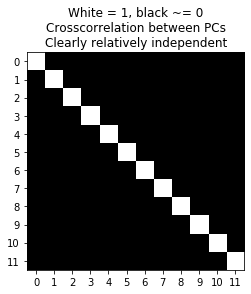

[[ 1.00000000e+00  1.78131993e-14  2.15884884e-16 -1.75482206e-16]
 [ 1.78131993e-14  1.00000000e+00 -1.00870230e-16  5.91829360e-17]
 [ 2.15884884e-16 -1.00870230e-16  1.00000000e+00  3.55722874e-16]
 [-1.75482206e-16  5.91829360e-17  3.55722874e-16  1.00000000e+00]]


In [72]:
plt.imshow(np.corrcoef(all_pcs.transpose()), cmap = 'gray')
plt.title(f"White = 1, black ~= 0\nCrosscorrelation between PCs\nClearly relatively independent")
plt.xticks([i for i in range(0, 12)])
plt.yticks([i for i in range(0, 12)])
plt.show()
print(np.corrcoef(all_pcs[ : , : 4].transpose()))

In [69]:
pcs_mean = all_pcs[ : , : 4].mean(axis = 0)
pcs_cov  = np.cov(all_pcs[ : , : 4], rowvar = 0)

print(pcs_mean.shape)
print(pcs_cov.shape)

print(pcs_mean)
print(pcs_cov)

(4,)
(4, 4)
[ 8.04633322e-14 -2.93241802e-13 -4.68803226e-13 -5.47275244e-13]
[[ 3.83378626e+03  3.37968912e-11  3.27630655e-13 -2.45267784e-13]
 [ 3.37968912e-11  9.38948468e+02 -7.57586514e-14  4.09365142e-14]
 [ 3.27630655e-13 -7.57586514e-14  6.00754031e+02  1.96812924e-13]
 [-2.45267784e-13  4.09365142e-14  1.96812924e-13  5.09550166e+02]]


In [20]:
idxSum = 0
idxs = []
for session in sorted(dataDict.keys()):
    lo = idxSum
    for channel in sorted(dataDict[session].keys()):
        idxSum += dataDict[session][channel].shape[0]
    hi = idxSum
    idxs.append((session, lo, hi))
    
for s, l, h in idxs:
    print((s, l, h))

('NPR-073.d04', 0, 19475)
('NPR-073.d08', 19475, 36657)
('NPR-075.b11', 36657, 56807)
('NPR-075.b13', 56807, 77678)
('NPR-075.c013', 77678, 93911)
('NPR-075.c08', 93911, 111027)
('NPR-075.d07', 111027, 130377)
('NPR-076.b05', 130377, 145083)
('NPR-076.b09', 145083, 162839)
('NPR-076.c09', 162839, 181487)
('NPR-076.d07', 181487, 200207)
('NPR040.c12', 200207, 225039)
('NPR040.d12', 225039, 235127)
('NPR052d.05', 235127, 250667)
('NPR052e.10', 250667, 262367)
('NPR064.b08', 262367, 273259)
('NPR064.c09', 273259, 315433)
('NPR065c.10', 315433, 320353)
('NPR065e.03', 320353, 343633)
('pjx289c.01', 343633, 355213)
('pjx289e08', 355213, 367629)


In [86]:
all_str = []
all_gp  = []
for _, channels in dataDict.items():
    for channel, vals in channels.items():
        if "str_lfp" in channel:
            all_str.append(vals)
        if "gp_lfp" in channel:
            all_gp.append(vals)
all_str = pca_model.transform(np.concatenate(all_str, axis = 0)[ : , epoch_idxs].copy())
all_gp =  pca_model.transform(np.concatenate(all_gp , axis = 0)[ : , epoch_idxs].copy())

print(all_str.shape)
print(all_gp.shape)

(131208, 12)
(236421, 12)


(236421, 2)

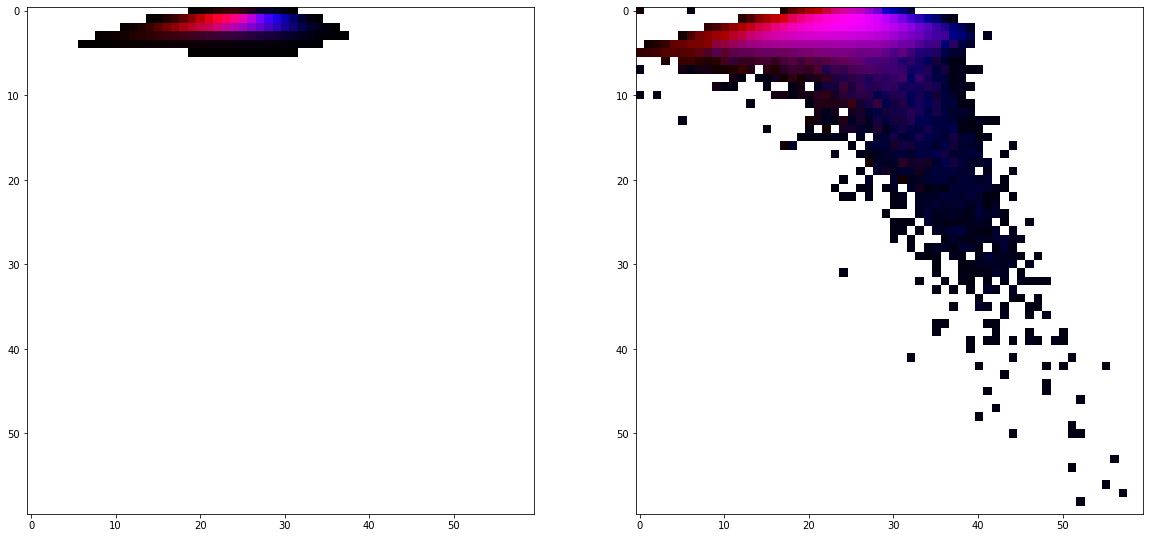

In [130]:
maxx1 = np.max((
    np.max(all_str[ : , 0]),
    np.max( all_gp[ : , 0])
))

maxx2 = np.max((
    np.max(all_str[ : , 1]),
    np.max( all_gp[ : , 1])
))

minx1 = np.max((
    np.min(all_str[ : , 0]),
    np.min( all_gp[ : , 0])
))

minx2 = np.max((
    np.min(all_str[ : , 1]),
    np.min( all_gp[ : , 1])
))

extrapoints = np.array((
    maxx1, maxx2, maxx1, minx2,
    minx1, maxx2, minx1, minx2
)).reshape((4, 2))

side = 60

red = rasterize(
    np.concatenate([
        all_str[ : , : 2], extrapoints
    ], axis = 0),
    side
)

blu = rasterize(
    np.concatenate([
        all_gp[ : , : 2], extrapoints
    ], axis = 0),
    side
)

redlg2 = np.log2(red + 1)
blulg2 = np.log2(blu + 1)

red /= np.max(red)
blu /= np.max(blu)
redlg2 /= np.max(redlg2)
blulg2 /= np.max(blulg2)
raster = np.zeros((side, side, 3))
raster[ : , : , 0] = red
raster[ : , : , 2] = blu
rasterlg2 = np.zeros(raster.shape)
rasterlg2[ : , : , 0] = redlg2
rasterlg2[ : , : , 2] = blulg2

plt.figure(figsize = (20, 10))

for i in range(0, side):
    for j in range(0, side):
        if np.linalg.norm(raster[i, j]) < 0.01:
            raster[i, j] = 1
plt.subplot(1, 2, 1)
plt.imshow(raster)

for i in range(0, side):
    for j in range(0, side):
        if np.linalg.norm(rasterlg2[i, j]) < 0.01:
            rasterlg2[i, j] = 1
plt.subplot(1, 2, 2)
plt.imshow(rasterlg2)

plt.show()

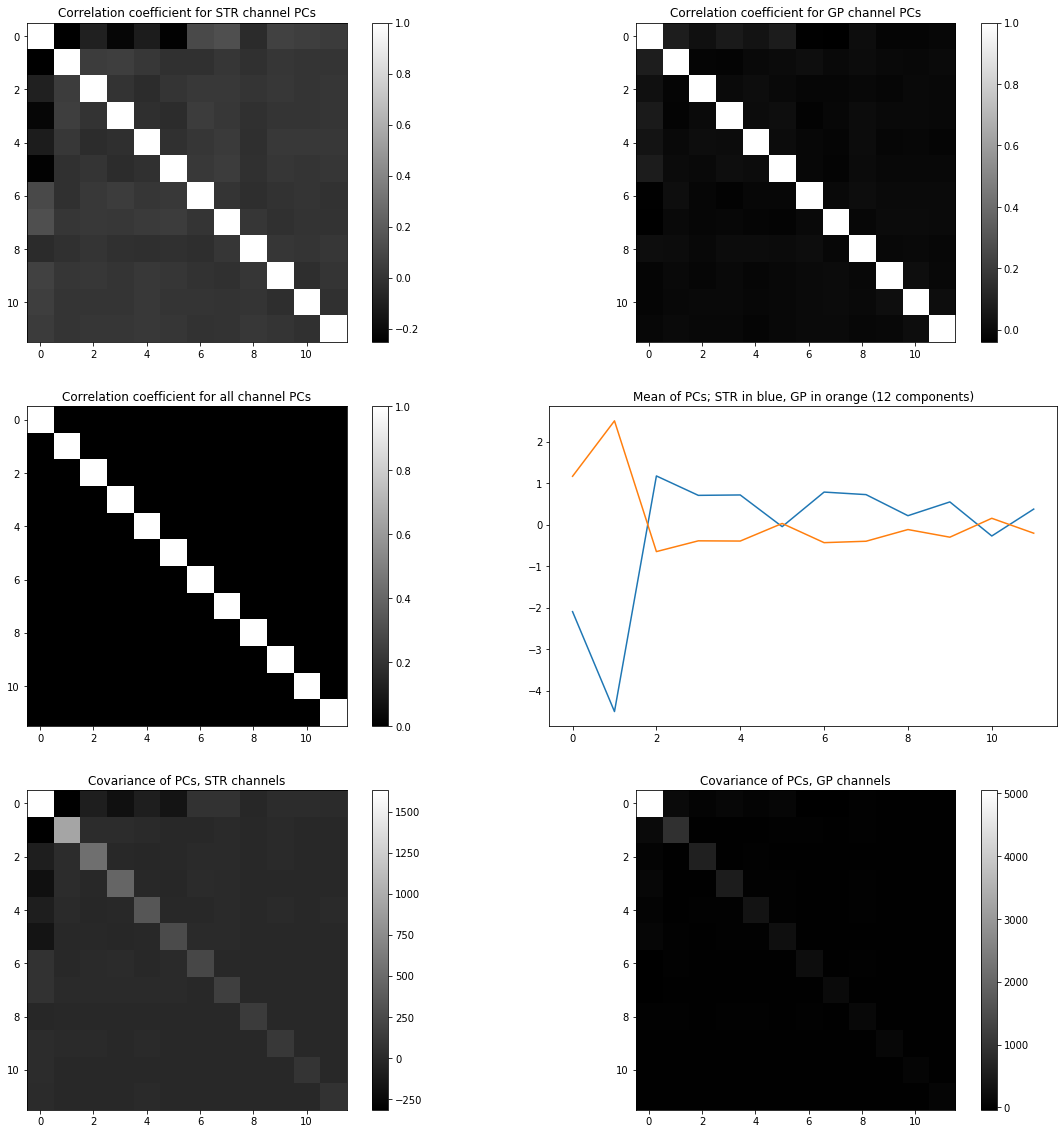

In [103]:
plt.figure(figsize = (20, 20))

plt.subplot(3, 2, 1)
plt.title("Correlation coefficient for STR channel PCs")
plt.imshow(np.corrcoef(all_str.transpose()), cmap = 'gray')
plt.colorbar()

plt.subplot(3, 2, 2)
plt.title("Correlation coefficient for GP channel PCs")
plt.imshow(np.corrcoef(all_gp.transpose()), cmap = 'gray')
plt.colorbar()

plt.subplot(3, 2, 3)
plt.title("Correlation coefficient for all channel PCs")
plt.imshow(np.corrcoef(all_pcs.transpose()), cmap = 'gray')
plt.colorbar()

plt.subplot(3, 2, 4)
plt.title("Mean of PCs; STR in blue, GP in orange (12 components)")
plt.plot(all_str.mean(axis = 0))
plt.plot(all_gp.mean(axis = 0))

plt.subplot(3, 2, 5)
plt.title("Covariance of PCs, STR channels")
plt.imshow(np.cov(all_str, rowvar = 0), cmap = 'gray')
plt.colorbar()

plt.subplot(3, 2, 6)
plt.title("Covariance of PCs, GP channels")
plt.imshow(np.cov(all_gp, rowvar = 0), cmap = 'gray')
plt.colorbar()

plt.show()